In [18]:
from sixdrepnet.dof_trt_utils import DoFEngine
import numpy as np
import cv2
import time
import os, sys
import argparse
from loguru import logger
import matplotlib.pyplot as plt

self.imgsz : (112, 112)
[0.58823529 0.78039216 0.94901961]


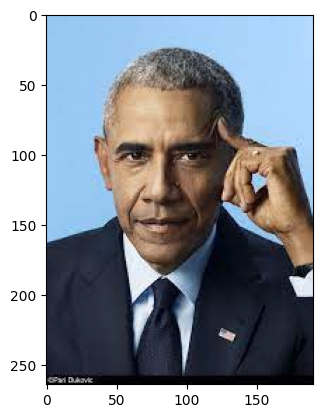

In [21]:
logger.add('./sixd.log')
trt_resnet = DoFEngine('./sixdrepnet/sixdresnet.trt', 'sixdresnet', logger=logger)
ori_img = cv2.imread('./image.jpg')
img = ori_img[:,:,::-1] / 255.0
print(img[0][0])
plt.imshow(img)

In [22]:
preprocess_img = trt_resnet.preprocess(img)
preprocess_img = np.ascontiguousarray(preprocess_img, dtype=np.float32)
print(preprocess_img.shape)

(3, 112, 112)


In [23]:
print(preprocess_img[0][0])

[0.4508093  0.45080927 0.45080927 0.4508092  0.4508093  0.4508093
 0.4508092  0.45080927 0.45080927 0.47196868 0.4850588  0.48505875
 0.48505875 0.48505872 0.4850588  0.4850588  0.48505872 0.48505878
 0.48909342 0.50218356 0.50218356 0.50218356 0.5021835  0.5115079
 0.51930827 0.5193083  0.51930827 0.5193083  0.51930827 0.5209221
 0.536433   0.55221295 0.5507784  0.536433   0.53643304 0.5364331
 0.5364331  0.5687101  0.6100426  0.6242086  0.6391815  0.6554994
 0.6563063  0.6563063  0.6563062  0.6563063  0.6563064  0.6563062
 0.6619548  0.6761208  0.6905558  0.6837418  0.6772864  0.6905558
 0.6985353  0.70768064 0.7197845  0.7248052  0.72480536 0.72480536
 0.72480536 0.7248053  0.72480536 0.72480536 0.7248052  0.7248054
 0.72480536 0.7344883  0.7419301  0.7557375  0.7482062  0.74193007
 0.75690305 0.77106905 0.7761796  0.7600412  0.7590549  0.75905484
 0.7590548  0.75905484 0.75905484 0.7590548  0.75905484 0.75905484
 0.78783524 0.8104291  0.81042916 0.8104291  0.81042904 0.8104291
 0.8

In [24]:
output = trt_resnet.infer(preprocess_img)
out = output[0].reshape(1, -1)
print(out.shape)
print(out)

(1, 6)
[[ 6.140625   -0.38671875 -0.20324707 -0.19177246  5.1914062  -0.85498047]]


In [25]:
def normalize_vector(v):
    batch = v.shape[0]
    v_mag = np.sqrt(np.power(v, 2).sum(1))# batch
    eps = np.array([1e-8], dtype=np.float32)
    v_mag = np.maximum(v_mag, eps)
    v_mag = v_mag.reshape(batch, 1)
    v = v/v_mag
    return v
    
# u, v batch*n
def cross_product(u, v):
    batch = u.shape[0]
    #print (u.shape)
    #print (v.shape)
    i = u[:,1]*v[:,2] - u[:,2]*v[:,1]
    j = u[:,2]*v[:,0] - u[:,0]*v[:,2]
    k = u[:,0]*v[:,1] - u[:,1]*v[:,0]
        
    out = np.concatenate((i.reshape(batch,1), j.reshape(batch,1), k.reshape(batch,1)),1) #batch*3
        
    return out
        

def compute_rotation_matrix_from_ortho6d(poses):
    x_raw = poses[:,0:3] #batch*3
    y_raw = poses[:,3:6] #batch*3

    x = normalize_vector(x_raw) #batch*3
    z = cross_product(x,y_raw) #batch*3
    z = normalize_vector(z) #batch*3
    y = cross_product(z,x) #batch*3
    x = x.reshape(-1,3,1)
    y = y.reshape(-1,3,1)
    z = z.reshape(-1,3,1)
    matrix = np.concatenate((x,y,z), 2) #batch*3*3
    return matrix

def compute_euler_angles_from_rotation_matrices(rotation_matrices):
    batch = rotation_matrices.shape[0]
    R = rotation_matrices
    sy = np.sqrt(R[:,0,0]*R[:,0,0]+R[:,1,0]*R[:,1,0])
    singular = sy<1e-6
    singular = np.array(singular, dtype=np.float32)    
    x = np.arctan2(R[:,2,1], R[:,2,2])
    y = np.arctan2(-R[:,2,0], sy)
    z = np.arctan2(R[:,1,0],R[:,0,0])
    
    xs = np.arctan2(-R[:,1,2], R[:,1,1])
    ys = np.arctan2(-R[:,2,0], sy)
    zs = R[:,1,0]*0
    
    out_euler = np.zeros((batch, 3))
    out_euler[:,0] = x*(1-singular)+xs*singular
    out_euler[:,1] = y*(1-singular)+ys*singular
    out_euler[:,2] = z*(1-singular)+zs*singular
        
    return out_euler

from math import cos, sin
def draw_axis(img, yaw, pitch, roll, tdx=None, tdy=None, size = 100):
    """
    Prints the person's name and age.

    If the argument 'additional' is passed, then it is appended after the main info.

    Parameters
    ----------
    img : array
        Target image to be drawn on
    yaw : int
        yaw rotation
    pitch: int
        pitch rotation
    roll: int
        roll rotation
    tdx : int , optional
        shift on x axis
    tdy : int , optional
        shift on y axis
        
    Returns
    -------
    img : array
    """

    pitch = pitch * np.pi / 180
    yaw = -(yaw * np.pi / 180)
    roll = roll * np.pi / 180

    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),4)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),4)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),4)

    return img

[[[ 0.9974788   0.05649902  0.04294197]
  [-0.06281832  0.98447543  0.16389675]
  [-0.03301531 -0.16618107  0.9855424 ]]]
[[-9.57111847  1.89198161 -3.60356298]]


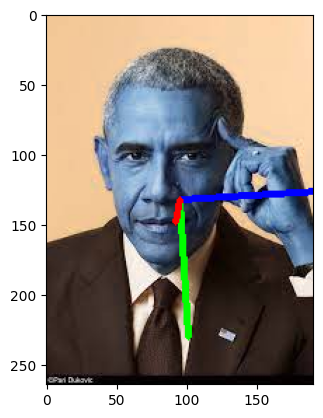

In [26]:
output_rotate_matrix = compute_rotation_matrix_from_ortho6d(out)
print(output_rotate_matrix)
euler = compute_euler_angles_from_rotation_matrices(output_rotate_matrix)*180/np.pi
print(euler)
pitch, yaw, roll = euler[:, 0], euler[:, 1], euler[:, 2]

new_img = draw_axis(ori_img, yaw, pitch, roll)
plt.imshow(new_img)

In [8]:
pitch, yaw, roll

(array([-4.74210216]), array([0.69851544]), array([4.2086964]))

In [27]:
len(None)

TypeError: object of type 'NoneType' has no len()

In [28]:
a = np.array([1,2,3])
if a:
    print(1)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()